# Acknowledgements

The code for the transformer model is take from  this tutorial https://www.tensorflow.org/text/tutorials/transformer

# Installing Packages needed and Importing Libraries

In [1]:
!pip install openpyxl  --quiet

In [2]:
from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [12]:
ENCODER_LEN = 400
DECODER_LEN = 75
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# Dataset

After creating the dataframe we apply Start of Sentence(<SOS>) and End of Sentence(<EOS>) tokens.
These sentences are then tokenized and padded to fix length.

In [5]:
#Jair
duc=pd.read_excel("/content/duc_2004.xlsx",engine = 'openpyxl')

#Evan
#duc=pd.read_excel("/content/drive/MyDrive/SD_data/duc_2004.xlsx",engine = 'openpyxl')

In [6]:
duc.head()

,text,summary1,summary2,summary3,summary4
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...,Cambodian leader Hun Sen rejects opposition de...,"Hun Sen rejects out of country talks, Sihanouk...",New Cambodian government in limbo as Hun Sen r...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...,Sihanouk refuses to host talks of Cambodian po...,"Efforts to form a government deadlocked, Sihan...",Norodom Sihanouk declines role to mediate in C...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb...",Cambodian opposition asks ADB to stop loans to...,Cambodia's two-party opposition seeks to block...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...,CPP defends Hun Sen to US Senate. Asks rejecti...,Cambodia's ruling party seeks to counter human...,US House seeks probe of Cambodian rights viola...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...,FUNCINPEC refuses to share presidency with CPP...,Disputes over presidency block efforts to form...,Opposition Royalists reject power sharing and ...


In [7]:
#Jair
news = pd.read_excel("/content/inshorts.xlsx",engine = 'openpyxl')

#Evan
#news = pd.read_excel("/content/drive/MyDrive/SD_data/inshorts.xlsx",engine = 'openpyxl')


print(f'Dataset size: {len(news)}')

Dataset size: 55104


In [8]:
news.head()

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [9]:
news_article_len = pd.Series([len(x) for x in news['Short']])
news_summary_len = pd.Series([len(x) for x in news['Headline']])

In [10]:
news_article_len.describe()

,0
count,55104.000000
mean,368.003049
std,26.235510
min,280.000000
25%,350.000000
50%,369.000000
75%,387.000000
max,469.000000


In [11]:
news_summary_len.describe()

,0
count,55104.000000
mean,51.620282
std,7.267463
min,8.000000
25%,47.000000
50%,51.000000
75%,57.000000
max,84.000000


In [13]:
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [14]:
duc_columns = duc.columns.tolist()
duc_columns.remove('text')
duc_columns.remove('summary1')
duc.drop(duc_columns, axis='columns', inplace=True)


In [15]:
duc

,text,summary1
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [16]:
duc.rename(columns = { 'summary1':'Headline','text':'Short'}, inplace = True)

In [17]:
duc

,Short,Headline
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [18]:
news

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [19]:
#df = pd.concat([duc, news])
#del df1, df2
df = pd.concat([duc, news], ignore_index=True, sort=False)
# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
news=df

Dataset size: 55604


In [20]:
news.head()

,Short,Headline
0,The memorial of late President APJ Abdul Kalam...,Ex-Prez Abdul Kalam&#39;s memorial to open on ...
1,Jammu &amp; Kashmir&#39;s Teachers Unions on S...,J&amp;K teachers protest &#39;humiliation&#39;...
2,Mumbai has been named the most expensive city ...,TripAdvisor ranks Mumbai costliest Indian city
3,Delhi&#39;s Transport Minister Gopal Rai on Sa...,"Delhi govt will add 1,000 premium buses: Rai"
4,"As per reports, Pakistan Cricket Board (PCB) h...",‘PCB lost $100mn due to India’s refusal to pla...


In [21]:
text= " my name is sandeep&#39;s kumar"
text=text.replace(r'&#39;','`')#.replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)

In [22]:
text

' my name is sandeep`s kumar'

In [23]:
news=news.replace(r'&#45;','-', regex=True).replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)
news.head()

,Short,Headline
0,The memorial of late President APJ Abdul Kalam...,Ex-Prez Abdul Kalam`s memorial to open on July 27
1,Jammu &; Kashmir`s Teachers Unions on Saturday...,J&;K teachers protest `humiliation` due to reform
2,Mumbai has been named the most expensive city ...,TripAdvisor ranks Mumbai costliest Indian city
3,Delhi`s Transport Minister Gopal Rai on Saturd...,"Delhi govt will add 1,000 premium buses: Rai"
4,"As per reports, Pakistan Cricket Board (PCB) h...",‘PCB lost $100mn due to India’s refusal to pla...


In [24]:
article = news['Short']
summary = news['Headline']

In [26]:
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [27]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [28]:
article[8]

'<SOS> Low-cost airline SpiceJet would not “go crazy” about market share and will focus on remaining profitable in a responsible manner, Chairman Ajay Singh said. “Market share will happen as we increase our planes and flights,” he stated. Notably, with seven straight quarters of profit after being near closure in 2015, SpiceJet is currently fourth in terms of domestic market share. <EOS>'

In [29]:

print("****************************")
summary[8]

****************************


'<SOS> SpiceJet won`t go crazy about market share: Chairman <EOS>'

In [30]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [31]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76618 29955


In [32]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
train_dataset, val_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.8)

In [35]:
print(article_tokenizer.word_index.get('<eos>', 1))
print(article_tokenizer.word_index.get('<sos>', 2))
print(summary_tokenizer.word_index.get('<eos>', 1))
print(summary_tokenizer.word_index.get('<sos>', 2))

1
2
3
2


# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [36]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [39]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        attention_weights['decoder_layer{}_block1'.format(1)] = attn_weights_block1
        attention_weights['decoder_layer{}_block2'.format(1)] = attn_weights_block2

        return out3, attention_weights

In [40]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tf.shape(x)[1], :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)  # Pass 'training' as keyword argument

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, dec_padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, attn_weights = self.dec_layers[i](x, enc_output, training=training,
                                                 look_ahead_mask=look_ahead_mask,
                                                 padding_mask=dec_padding_mask)
            attention_weights.update(attn_weights)

        return x, attention_weights

In [41]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training=training,
                                                     look_ahead_mask=look_ahead_mask,
                                                     dec_padding_mask=dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def summary(self):
        super(Transformer, self).summary()
        print("Encoder:")
        self.encoder.summary()
        print("Decoder:")
        self.decoder.summary()
        print("Final Layer:")
        self.final_layer.summary()

In [42]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.2
EPOCHS = 30

# Custom Learning Rate

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


# optimizer = tf.keras.optimizers.AdamW(
#     learning_rate=learning_rate,
#     beta_1=0.9,
#     beta_2=0.98,
#     epsilon=1e-9,
#     weight_decay=0.01  # You can adjust this value based on your needs
# )

Text(0.5, 0, 'Train Step')

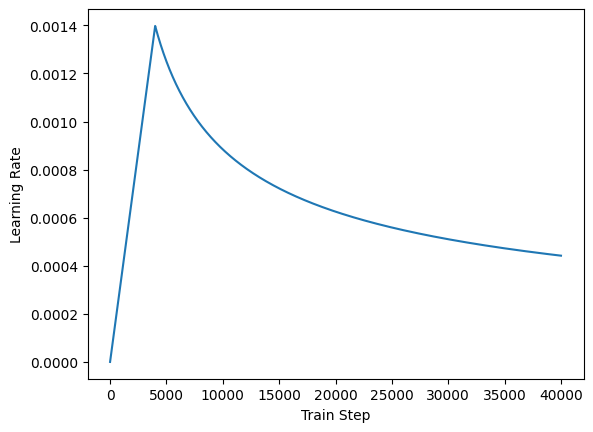

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [47]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [48]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [49]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [51]:
@tf.function
def train_step(inputs, targets):
    tar_inp = targets[:, :-1]
    tar_real = targets[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inputs, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inputs, tar_inp,
            training=True,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

    #return loss, accuracy_function(tar_real, predictions)

In [52]:
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

In [53]:
# prompt: write function for validation step

@tf.function
def val_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  predictions, _ = transformer(
      inp, tar_inp,
      training=False,
      enc_padding_mask=enc_padding_mask,
      look_ahead_mask=combined_mask,
      dec_padding_mask=dec_padding_mask
  )

  loss = loss_function(tar_real, predictions)

  val_loss(loss)
  val_accuracy(accuracy_function(tar_real, predictions))


# Training the Model

In [54]:
import time

# Initialize lists to store training and validation losses and accuracies
epoch_train_losses = []
epoch_train_accuracies = []
epoch_val_losses = []
epoch_val_accuracies = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

In [55]:
def train_one_epoch(train_dataset):
    """Train the model for one epoch and return the average loss and accuracy."""
    cumulative_loss = 0
    cumulative_accuracy = 0
    num_batches = 0

    for (batch, (inputs, targets)) in enumerate(train_dataset):
        train_step(inputs, targets)
        cumulative_loss += train_loss.result()
        cumulative_accuracy += train_accuracy.result()
        num_batches += 1

        if batch % 100 == 0:
            print(f'Batch {batch} Training Loss {train_loss.result():.4f} Training Accuracy {train_accuracy.result():.4f}')

    # Average loss and accuracy for the epoch
    return cumulative_loss / num_batches, cumulative_accuracy / num_batches

In [56]:
def validate_one_epoch(val_dataset):
    """Validate the model for one epoch and return the average loss and accuracy."""
    for (inputs, targets) in val_dataset:
        val_step(inputs, targets)

    return val_loss.result(), val_accuracy.result()

In [57]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    # Train for one epoch
    epoch_train_loss, epoch_train_accuracy = train_one_epoch(train_dataset)
    epoch_train_losses.append(epoch_train_loss)
    epoch_train_accuracies.append(epoch_train_accuracy)

    # Validate for one epoch
    epoch_val_loss, epoch_val_accuracy = validate_one_epoch(val_dataset)
    epoch_val_losses.append(epoch_val_loss)
    epoch_val_accuracies.append(epoch_val_accuracy)

    # Save checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

    # Print results for the epoch
    print(f'Epoch {epoch + 1} Training Loss {epoch_train_loss:.4f} Training Accuracy {epoch_train_accuracy:.4f}')
    print(f'Epoch {epoch + 1} Validation Loss {epoch_val_loss:.4f} Validation Accuracy {epoch_val_accuracy:.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        ckpt_save_path = ckpt_manager.save()
        print(f'New best validation loss. Model saved at {ckpt_save_path}.')
    else:
        epochs_without_improvement += 1

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        ckpt_save_path = ckpt_manager.save()
        print(f'Model saved at {ckpt_save_path} before stopping.')
        break

Batch 0 Training Loss 10.3090 Training Accuracy 0.0000
Batch 100 Training Loss 10.2051 Training Accuracy 0.0615
Batch 200 Training Loss 9.9926 Training Accuracy 0.0825
Batch 300 Training Loss 9.6921 Training Accuracy 0.0896
Batch 400 Training Loss 9.3486 Training Accuracy 0.0931
Batch 500 Training Loss 9.0343 Training Accuracy 0.0951
Batch 600 Training Loss 8.7903 Training Accuracy 0.0966
Epoch 1 Training Loss 9.5110 Training Accuracy 0.0805
Epoch 1 Validation Loss 7.4371 Validation Accuracy 0.1177
Time taken for 1 epoch: 389.21 secs

New best validation loss. Model saved at checkpoints/ckpt-1.
Batch 0 Training Loss 7.4866 Training Accuracy 0.1225
Batch 100 Training Loss 7.3940 Training Accuracy 0.1235
Batch 200 Training Loss 7.3487 Training Accuracy 0.1271
Batch 300 Training Loss 7.3080 Training Accuracy 0.1293
Batch 400 Training Loss 7.2688 Training Accuracy 0.1306
Batch 500 Training Loss 7.2340 Training Accuracy 0.1321
Batch 600 Training Loss 7.1958 Training Accuracy 0.1334
Epoch 2 

Above is changes to get validation loss and accuracy, below is original

In [ ]:
# for epoch in range(EPOCHS):
#     start = time.time()

#     epoch_loss = 0
#     epoch_accuracy = 0
#     num_batches = 0

#     for (batch, (inp, tar)) in enumerate(dataset):
#         batch_loss, batch_accuracy = train_step(inp, tar)
#         train_loss.update_state(batch_loss)
#         train_accuracy.update_state(batch_accuracy)
#         epoch_loss = train_loss.result()
#         epoch_accuracy = train_accuracy.result()
#         num_batches += 1

#         if batch % 100 == 0:
#             current_loss = epoch_loss / (batch + 1)
#             current_accuracy = epoch_accuracy / (batch + 1)
#             print(f'Epoch {epoch + 1} Batch {batch} Loss {current_loss:.4f} Accuracy {current_accuracy:.4f}')

#     epoch_loss = epoch_loss / num_batches
#     epoch_accuracy = epoch_accuracy / num_batches

#     losses.append(epoch_loss)
#     accuracies.append(epoch_accuracy)

#     if (epoch + 1) % 5 == 0:
#         ckpt_save_path = ckpt_manager.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

#     print(f'Epoch {epoch + 1} Loss {epoch_loss:.4f} Accuracy {epoch_accuracy:.4f}')
#     print(f'Time taken for 1 epoch: {time.time() - start} secs\n')

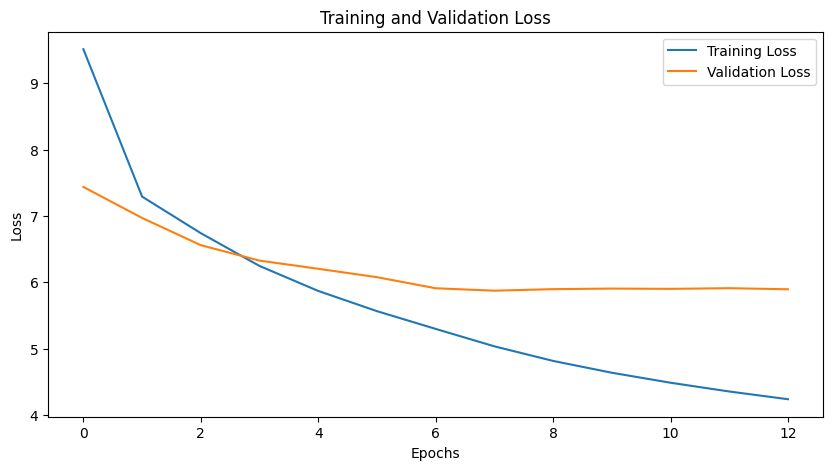

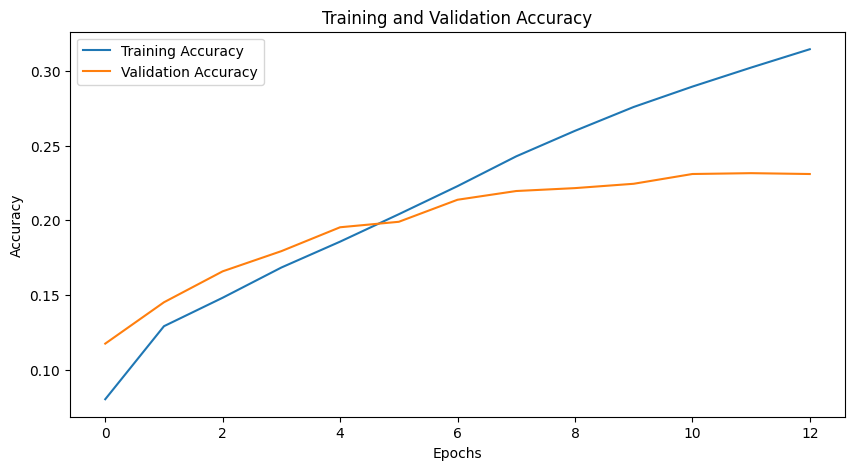

In [58]:
# prompt: write code to plot train and val graphs

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_train_accuracies, label='Training Accuracy')
plt.plot(epoch_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# prompt: save the trained model

# Save the entire model as a SavedModel.
transformer.save('my_transformer_model.keras')

# Alternatively, save only the weights.
#transformer.save_weights('/content/drive/MyDrive/SD_data/my_transformer_weights.weights.h5')


# Evaluation

In [59]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask

        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [60]:
def summarize(input_article):
    input_article=preprocess(input_article)
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]

# Predictions

Below me make predictions on some texts to see how the model is performimg. Since this was a very basic approach the model wont perform that well but it can surely be improved.

In [61]:
article[5]

'<SOS> Danish tourist Johnny Bonde was bitten by a freshwater crocodile at Lake Kununurra in Australia, after accidentally "body-slamming" the reptile, while attempting to take a photo of it, reports said. Bonde`s right arm was bitten by the 2.5-metre-long crocodile. "I pretty much body-slammed him. If somebody body-slammed me at night, I would be angry too," the 27-year-old said. <EOS>'

In [62]:
print("Real Headline : ", summary[5][5:-5],"\n Predicted Summary : ", summarize(article[5]))

Real Headline :   Danish tourist bitten after `body-slamming` crocodile  
 Predicted Summary :  thousands of cancer patient found guilty of 42k guests


In [63]:
article[16]

'<SOS> Singer Sia, known for songs like `Cheap Thrills` and `Chandelier`, was spotted without her wig at the Los Angeles airport on her way to Dubai. The 41-year-old singer usually makes public appearances wearing a half-black-half-blonde faux hair and never shows her face. Sia has introduced her distinctive look in her videos, where dancer Maddie Ziegler is seen in similar wigs.  <EOS>'

In [64]:
print("Real Headline : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Real Headline :   `Cheap Thrills` singer Sia spotted without her wig  
Predicted Summary :  designer sings journalist s daughter song from famous by famous students


In [65]:
article[23]

'<SOS> The parasite causing African sleeping sickness, a life-threatening disease, has been found to take refuge in and transmit through human skin. People with the parasite often show no symptoms of the disease and test negative to blood tests, leading to delayed diagnosis and less survival chances. This information can help eradicate the disease, which killed an estimated 9,000 in 2010. <EOS>'

In [66]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   `African sleeping sickness hides in human skin`  
Predicted Summary :  why do we have a human eye shaped camera


In [67]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   Ex-Prez Abdul Kalam`s memorial to open on July 27  
Predicted Summary :  pm modi to visit india for 1st time in uk


In [68]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   `African sleeping sickness hides in human skin`  
Predicted Summary :  why do we have a human eye shaped camera


In [69]:
summarize("Text Summarization - as the name suggests - involves generating short summaries of text data, in a few words or sentences. A good example of this in day-to-day life is the Inshorts news summary app, which generates summaries upto max of ~ 60 words.")

'why do we believe in their skin'

In [70]:
summarize("""Cambodian leader Hun Sen on Friday rejected opposition parties' demands
for talks outside the country, accusing them of trying to ``internationalize''
the political crisis. Government and opposition parties have asked
King Norodom Sihanouk to host a summit meeting after a series of post-election
negotiations between the two opposition groups and Hun Sen's party
to form a new government failed. Opposition leaders Prince Norodom
Ranariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition
figures after two alleged attempts on his life, said they could not
negotiate freely in Cambodia and called for talks at Sihanouk's residence
in Beijing. Hun Sen, however, rejected that. ``I would like to make
it clear that all meetings related to Cambodian affairs must be conducted
in the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet
meeting on Friday. ``No-one should internationalize Cambodian affairs.
It is detrimental to the sovereignty of Cambodia,'' he said. Hun Sen's
Cambodian People's Party won 64 of the 122 parliamentary seats in
July's elections, short of the two-thirds majority needed to form
a government on its own. Ranariddh and Sam Rainsy have charged that
Hun Sen's victory in the elections was achieved through widespread
fraud. They have demanded a thorough investigation into their election
complaints as a precondition for their cooperation in getting the
national assembly moving and a new government formed. Hun Sen said
on Friday that the opposition concerns over their safety in the country
was ``just an excuse for them to stay abroad.'' Both Ranariddh and
Sam Rainsy have been outside the country since parliament was ceremonially
opened on Sep. 24. Sam Rainsy and a number of opposition figures have
been under court investigation for a grenade attack on Hun Sen's Phnom
Penh residence on Sep. 7. Hun Sen was not home at the time of the
attack, which was followed by a police crackdown on demonstrators
contesting Hun Sen's election victory. The Sam Rainsy Party, in a
statement released Friday, accused Hun Sen of being ``unwilling to
make any compromise'' on negotiations to break the deadlock. ``A meeting
outside Cambodia, as suggested by the opposition, could place all
parties on more equal footing,'' said the statement. ``But the ruling
party refuses to negotiate unless it is able to threaten its negotiating
partners with arrest or worse.'' """)

'un panel recommends un resolution on un resolution'

In [71]:
summarize("cambodian leader hun sen on friday rejected opposition parties ' demands for talks outside the country , accusing them of trying to `` internationalize '' the political crisis .")

'congo govt rejects rules with sedition law'

Cambodian government rejects opposition's call for talks abroad


In [72]:
summarize("king norodom sihanouk has declined requests to chair a summit of cambodia 's top political leaders , saying the meeting would not bring any progress in deadlocked negotiations to form a government .")

'uk govt rejects pm s resignation over brexit'

In [73]:
summarize("sometime in the summer of 1997 , an operative for osama bin laden sat down at his personal computer in a hideaway in kenya , he was worried , he wrote in an angry dispatch , about the security of the `` east africa network '' of bin laden , the saudi exile accused of masterminding a worldwide terrorist conspiracy against americans .")

'thousands of human eye shaped using cancer'

In [74]:
summarize("six months after president clinton traveled to beijing and challenged china 's leaders to move rapidly toward political reform , the administration 's policy of engaging beijing was called into question monday when chinese courts sentenced three of the nation 's most prominent dissidents to long jail sentences .")

'china accuses china of possible terrorism ex un chief'

In [75]:
summarize("fbi agents this week began questioning relatives of the victims of the aug. 7 u.s. embassy bombing as well as the seriously injured on request of the u.s. attorney 's office for the southern district of new york , a u.s. official said thursday .")

'turkey arrests un officials over probe'

In [76]:
summarize("Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.")

'amazon buys cloud startup wudstay acquires food startup klozee'

In [77]:
summarize("Actor Ranbir Kapoor worked as an assistant director for Sanjay Leela Bhansali&#39;s &#39;Black&#39; in 2005. He is also known to have assisted in the making of the 1996 film &#39;PremGranth&#39; and his father Rishi Kapoor&#39;s directorial debut &#39;Aa Ab Laut Chalen&#39; in 1999. The actor, who has won five Filmfare awards including Best Actor for &#39;Barfi!&#39;, turned 34 on Wednesday.")

'ranbir kapoor to star in the world s next film'

In [78]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   Ex-Prez Abdul Kalam`s memorial to open on July 27  
Predicted Summary :  pm modi to visit india for 1st time in uk


In [79]:
summarize("The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.")

'sbi arrests cbi over ₹1 300 crore cash cash cash in thane'

# ROUGE evaluation

In [80]:
!pip install rouge --quiet

In [81]:
from rouge import Rouge
import numpy as np

def calculate_rouge_scores(hypotheses, references):
    """
    Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores.

    Args:
    hypotheses (list): List of generated summaries
    references (list): List of reference summaries

    Returns:
    dict: Dictionary containing average ROUGE scores
    """
    rouge = Rouge()

    # Initialize lists to store individual scores
    rouge_1_f1 = []
    rouge_2_f1 = []
    rouge_l_f1 = []

    for hyp, ref in zip(hypotheses, references):
        # Calculate ROUGE scores
        scores = rouge.get_scores(hyp, ref)[0]

        # Extract F1 scores
        rouge_1_f1.append(scores['rouge-1']['f'])
        rouge_2_f1.append(scores['rouge-2']['f'])
        rouge_l_f1.append(scores['rouge-l']['f'])

    # Calculate average scores
    avg_rouge_1 = np.mean(rouge_1_f1)
    avg_rouge_2 = np.mean(rouge_2_f1)
    avg_rouge_l = np.mean(rouge_l_f1)

    return {
        'ROUGE-1': avg_rouge_1,
        'ROUGE-2': avg_rouge_2,
        'ROUGE-L': avg_rouge_l
    }

In [82]:
# Example usage
hypotheses = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step."
]

references = [
    "The fast brown fox leaps over the sleepy dog.",
    "The journey of a thousand miles starts with one step."
]

rouge_scores = calculate_rouge_scores(hypotheses, references)

print("ROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")

ROUGE Scores:
ROUGE-1: 0.6833
ROUGE-2: 0.3355
ROUGE-L: 0.6833


In [84]:
# Get a sample of articles from your dataset
sample_articles = article[:1000]  # Adjust the number as needed

# Generate summaries using your transformer model
transformer_summaries = [summarize(art) for art in sample_articles]

# Get the reference summaries
reference_summaries = summary[:1000]  # Adjust to match your sample size

# Calculate ROUGE scores for transformer model
transformer_rouge_scores = calculate_rouge_scores(transformer_summaries, reference_summaries)


print("Transformer Model ROUGE Scores:")
for metric, score in transformer_rouge_scores.items():
    print(f"{metric}: {score:.4f}")


Transformer Model ROUGE Scores:
ROUGE-1: 0.0697
ROUGE-2: 0.0097
ROUGE-L: 0.0669
